Import Libraries

In [7]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, accuracy_score,
                             precision_score, recall_score, f1_score)

# XGBoost
from xgboost import XGBClassifier
import xgboost as xgb

# Feature importance
from sklearn.inspection import permutation_importance

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("All libraries imported successfully!")

All libraries imported successfully!


Load the Dataset

In [8]:
# Load your preprocessed data
file_path = r'C:\Users\Yasara\Downloads\ATOMIC-DementiaPredictionModel\training_dataset.csv'
df = pd.read_csv(file_path)

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum().sum()} total missing values")

# Check data types
print(f"\nData types:\n{df.dtypes.value_counts()}")

Dataset loaded successfully!
Shape: (195195, 64)

First few rows:
   ALCOCCAS  ANXIETY  APNEA  ARTHRIT  BILLS  BIRTHMO  BIRTHYR  DEMENTED  \
0         2        2      1        1      1        5     1952         1   
1         2        1      1        1      2        5     1952         1   
2         2        1      1        1      1       12     1956         1   
3         1        1      1        1      4        1     1958         2   
4         2        1      1        1      1        2     1945         1   

   DEP2YRS  EDUC  EVENTS  GAMES  HATTMULT  HISPOR  INBIRMO  INBIRYR  INCALLS  \
0        1    16       2      1         3       8        5     1962        7   
1        1    16       2      1         3       8        5     1962        7   
2        1    16       1      1         3       8        3     1958        7   
3        1    16       4      4         3       1        9     1947        7   
4        1    12       1      1         3       1        2     1950        1   

  

Separate Features and Target

In [9]:
df.shape

(195195, 64)

Target column 'DEMENTED' found!

Features shape: (195195, 63)
Target shape: (195195,)

Class Distribution:
DEMENTED
1    137605
2     57590
Name: count, dtype: int64

Class Distribution (%):
DEMENTED
1    70.49617
2    29.50383
Name: proportion, dtype: float64


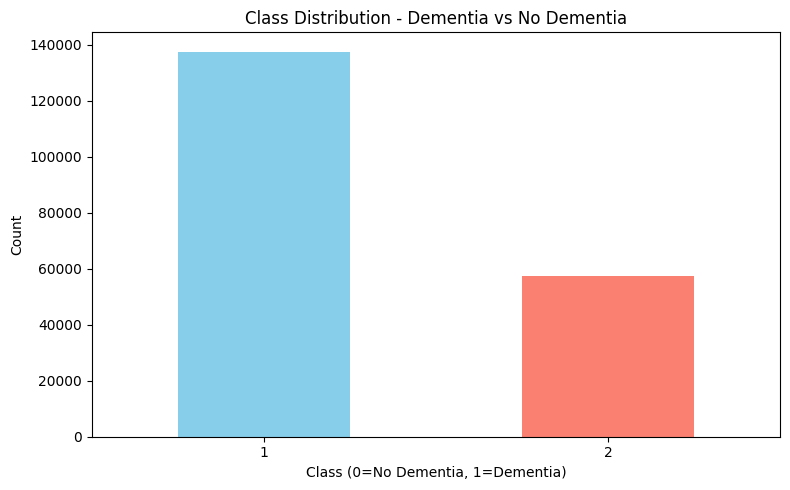

In [10]:
# Define target variable
target = 'DEMENTED'

# Check if target exists
if target not in df.columns:
    print(f"ERROR: Target column '{target}' not found!")
    print(f"Available columns: {df.columns.tolist()}")
else:
    print(f"Target column '{target}' found!")

# Separate features (X) and target (y)
X = df.drop(columns=[target])
y = df[target]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check class distribution
print(f"\nClass Distribution:")
print(y.value_counts())
print(f"\nClass Distribution (%):")
print(y.value_counts(normalize=True) * 100)

# Visualize class distribution
plt.figure(figsize=(8, 5))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution - Dementia vs No Dementia')
plt.xlabel('Class (0=No Dementia, 1=Dementia)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Split Data into Train and Test Sets

In [11]:
# Check current values in DEMENTED
print("Current DEMENTED values:")
print(df['DEMENTED'].value_counts().sort_index())

# Remap DEMENTED: 1 -> 0 (No Dementia), 2 -> 1 (Dementia)
# OR if 1 means Dementia and 2 means No Dementia, adjust accordingly
df['DEMENTED'] = df['DEMENTED'].map({1: 0, 2: 1})

# Verify the mapping
print("\nAfter remapping:")
print(df['DEMENTED'].value_counts().sort_index())

# Now separate features and target
X = df.drop(columns=['DEMENTED'])
y = df['DEMENTED']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Check class distribution
print(f"\nTrain set class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest set class distribution:")
print(y_test.value_counts().sort_index())

# Calculate class imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}")

Current DEMENTED values:
DEMENTED
1    137605
2     57590
Name: count, dtype: int64

After remapping:
DEMENTED
0    137605
1     57590
Name: count, dtype: int64

Training set size: (156156, 63)
Test set size: (39039, 63)

Train set class distribution:
DEMENTED
0    110084
1     46072
Name: count, dtype: int64

Test set class distribution:
DEMENTED
0    27521
1    11518
Name: count, dtype: int64

Class imbalance ratio: 2.39


Feature Scaling

In [12]:
# Note: XGBoost doesn't strictly require scaling, but it can help
# Uncomment if you want to scale features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("Feature scaling completed!")

print("Skipping feature scaling (XGBoost works well without it)")

Feature scaling completed!
Skipping feature scaling (XGBoost works well without it)


Build Baseline XGBoost Model

In [13]:
print("="*60)
print("BUILDING BASELINE XGBOOST MODEL")
print("="*60)

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Create baseline XGBoost model
baseline_xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1
)

# Train baseline model
print("\nTraining baseline model...")
baseline_xgb.fit(X_train, y_train)
print("Training completed!")

# Make predictions
y_pred_baseline = baseline_xgb.predict(X_test)
y_pred_proba_baseline = baseline_xgb.predict_proba(X_test)[:, 1]

# Evaluate baseline model
print("\n" + "="*60)
print("BASELINE MODEL PERFORMANCE")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_baseline):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_baseline):.4f}")

BUILDING BASELINE XGBOOST MODEL

Training baseline model...
Training completed!

BASELINE MODEL PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27521
           1       0.84      0.94      0.89     11518

    accuracy                           0.93     39039
   macro avg       0.91      0.93      0.92     39039
weighted avg       0.93      0.93      0.93     39039


Accuracy: 0.9298
Precision: 0.8414
Recall: 0.9390
F1-Score: 0.8875
ROC-AUC: 0.9833


Confusion Matrix Visualization - XGBoost

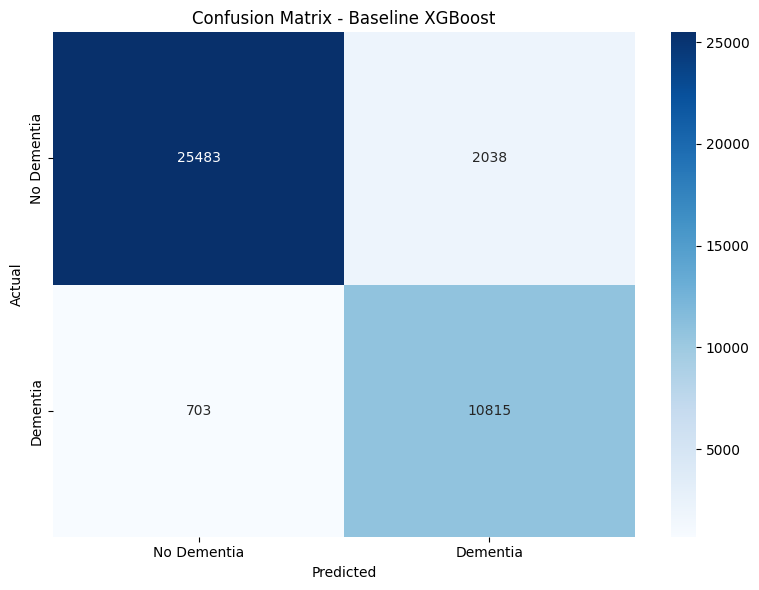


True Negatives: 25483
False Positives: 2038
False Negatives: 703
True Positives: 10815

Specificity: 0.9259
Sensitivity (Recall): 0.9390


In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Dementia', 'Dementia'],
            yticklabels=['No Dementia', 'Dementia'])
plt.title('Confusion Matrix - Baseline XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Specificity and Sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\nSpecificity: {specificity:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")

ROC Curve -XGBoost

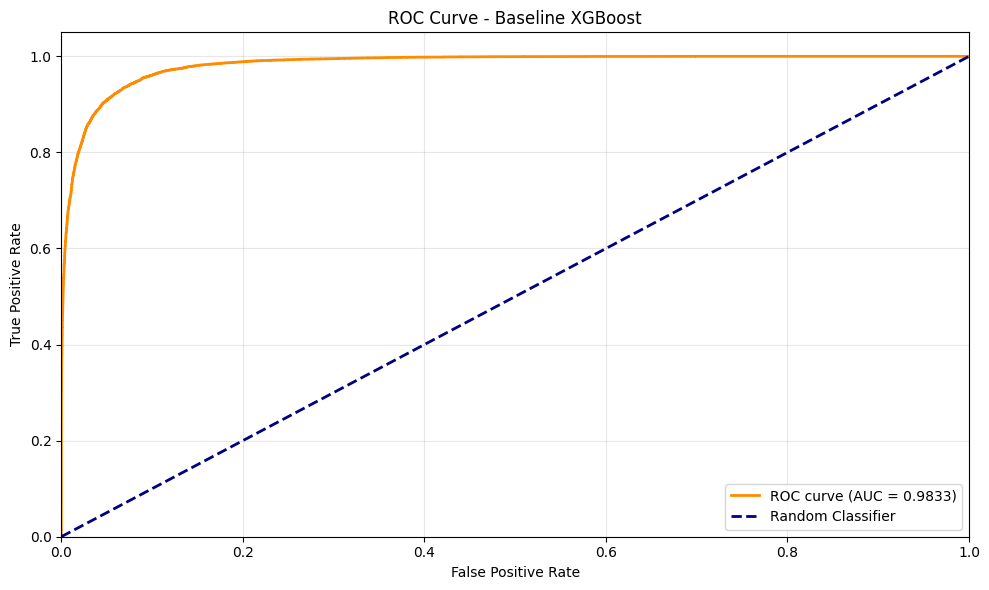

In [17]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_baseline)
roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline XGBoost')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Precision-Recall Curve - XGBoost

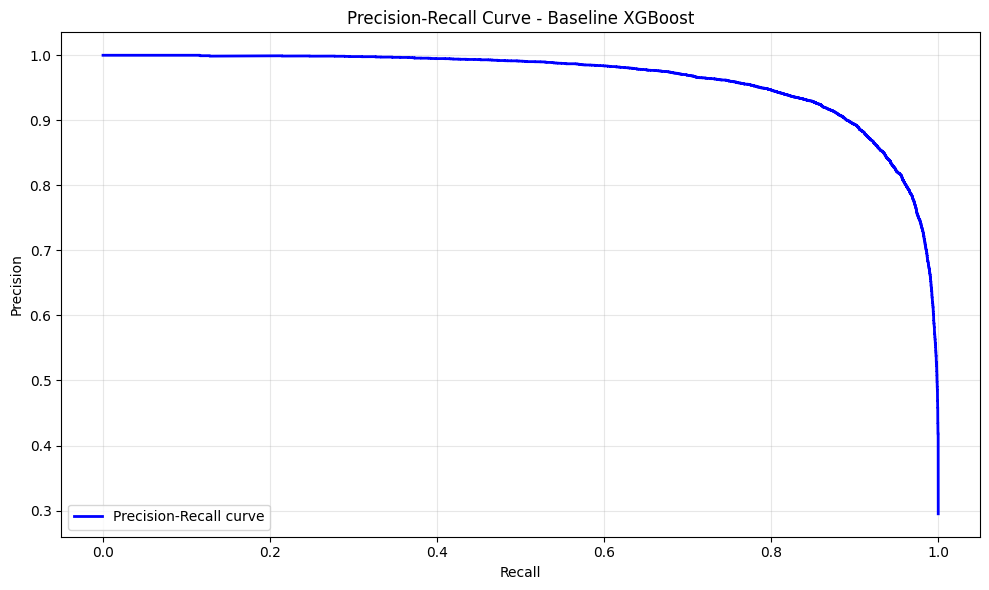

In [18]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_baseline)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Baseline XGBoost')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Hyperparameter Tuning with GridSearchCV -XGBoost

In [ ]:
print("="*60)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*60)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# For faster execution, use a smaller grid first
param_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 0.1]
}

# Choose which grid to use
# param_grid_to_use = param_grid_small  # Use this for faster tuning
param_grid_to_use = param_grid  # Use this for comprehensive tuning

# Create base model
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist'
)

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
print("\nStarting GridSearchCV...")
print(f"Total combinations to test: {np.prod([len(v) for v in param_grid_to_use.values()])}")
print("This may take several minutes...\n")

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_to_use,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    verbose=2,
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print("\nGridSearchCV completed!")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {grid_search.best_score_:.4f}")

Evaluate Tuned Model - XGBoost

In [ ]:
print("="*60)
print("TUNED MODEL PERFORMANCE")
print("="*60)

# Get best model
best_xgb = grid_search.best_estimator_

# Make predictions with tuned model
y_pred_tuned = best_xgb.predict(X_test)
y_pred_proba_tuned = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate tuned model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tuned):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")

# Compare with baseline
print("\n" + "="*60)
print("BASELINE vs TUNED MODEL COMPARISON")
print("="*60)
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [
        accuracy_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_baseline),
        roc_auc_score(y_test, y_pred_proba_baseline)
    ],
    'Tuned': [
        accuracy_score(y_test, y_pred_tuned),
        precision_score(y_test, y_pred_tuned),
        recall_score(y_test, y_pred_tuned),
        f1_score(y_test, y_pred_tuned),
        roc_auc_score(y_test, y_pred_proba_tuned)
    ]
})
comparison['Improvement'] = comparison['Tuned'] - comparison['Baseline']
print(comparison.to_string(index=False))

Feature Importance Analysis -XGBoost

In [ ]:
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from the model
feature_importance = best_xgb.feature_importances_

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20))

# Visualize top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save feature importance to CSV
feature_importance_df.to_csv('feature_importance_xgboost.csv', index=False)
print("\nFeature importance saved to 'feature_importance_xgboost.csv'")

Cross-Validation Score - XGBoost

In [ ]:
print("="*60)
print("CROSS-VALIDATION PERFORMANCE")
print("="*60)

# Perform cross-validation on the best model
cv_scores = cross_val_score(
    best_xgb, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"\nCross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f}")
print(f"Std CV ROC-AUC: {cv_scores.std():.4f}")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('ROC-AUC Score')
plt.title('Cross-Validation ROC-AUC Scores')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Save the Trained XGBoost Model

In [ ]:
import pickle

print("="*60)
print("SAVING THE MODEL")
print("="*60)

# Save the best model
model_filename = 'xgboost_dementia_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_xgb, file)

print(f"\nModel saved as '{model_filename}'")

# Save model parameters
params_filename = 'xgboost_best_params.txt'
with open(params_filename, 'w') as f:
    f.write("Best XGBoost Parameters:\n")
    f.write("="*50 + "\n")
    for param, value in grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")
    f.write("\n" + "="*50 + "\n")
    f.write(f"Best CV ROC-AUC Score: {grid_search.best_score_:.4f}\n")

print(f"Best parameters saved to '{params_filename}'")

# Test loading the model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Verify loaded model works
test_prediction = loaded_model.predict(X_test[:5])
print(f"\nModel loaded successfully! Test prediction: {test_prediction}")

Generate XGBoost Final Report Summary

In [ ]:
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)

final_report = f"""
XGBoost Dementia Prediction Model - Final Report
{'='*60}

Dataset Information:
- Total samples: {df.shape[0]}
- Total features: {X.shape[1]}
- Training samples: {X_train.shape[0]}
- Test samples: {X_test.shape[0]}
- Class imbalance ratio: {imbalance_ratio:.2f}

Best Hyperparameters:
{grid_search.best_params_}

Model Performance on Test Set:
- Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}
- Precision: {precision_score(y_test, y_pred_tuned):.4f}
- Recall: {recall_score(y_test, y_pred_tuned):.4f}
- F1-Score: {f1_score(y_test, y_pred_tuned):.4f}
- ROC-AUC: {roc_auc_score(y_test, y_pred_proba_tuned):.4f}

Cross-Validation Performance:
- Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})

Top 5 Most Important Features:
{feature_importance_df.head(5).to_string(index=False)}

Model saved as: {model_filename}
"""

print(final_report)

# Save report to file
with open('xgboost_model_report.txt', 'w') as f:
    f.write(final_report)

print("\nReport saved to 'xgboost_model_report.txt'")
print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)

Build Baseline Random Forest Model

In [19]:
print("="*80)
print("RANDOM FOREST MODEL TRAINING")
print("="*80)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, accuracy_score, precision_score, 
                             recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Build baseline Random Forest
print("\n" + "="*60)
print("BUILDING BASELINE RANDOM FOREST MODEL")
print("="*60)

baseline_rf = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Train baseline model
print("\nTraining baseline Random Forest...")
baseline_rf.fit(X_train, y_train)
print("Training completed!")

# Make predictions
y_pred_rf_baseline = baseline_rf.predict(X_test)
y_pred_proba_rf_baseline = baseline_rf.predict_proba(X_test)[:, 1]

# Evaluate baseline model
print("\n" + "="*60)
print("BASELINE RANDOM FOREST PERFORMANCE")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_baseline, 
                          target_names=['No Dementia', 'Dementia']))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_rf_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf_baseline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf_baseline):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf_baseline):.4f}")

RANDOM FOREST MODEL TRAINING

BUILDING BASELINE RANDOM FOREST MODEL

Training baseline Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.


Training completed!


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.1s finished



BASELINE RANDOM FOREST PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

 No Dementia       0.97      0.92      0.95     27521
    Dementia       0.84      0.93      0.88     11518

    accuracy                           0.92     39039
   macro avg       0.90      0.92      0.91     39039
weighted avg       0.93      0.92      0.93     39039


Accuracy: 0.9247
Precision: 0.8369
Recall: 0.9252
F1-Score: 0.8788
ROC-AUC: 0.9787


Confusion Matrix Visualization -Random Forest Model

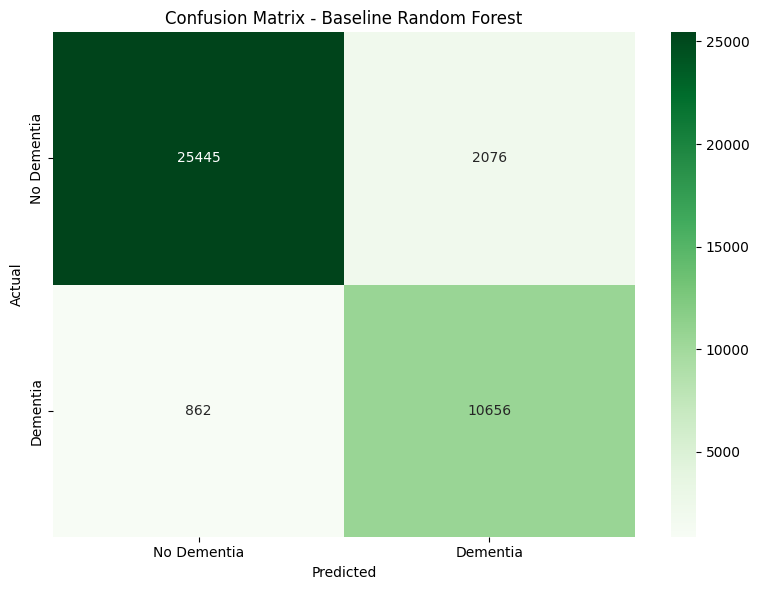


True Negatives: 25445
False Positives: 2076
False Negatives: 862
True Positives: 10656

Specificity: 0.9246
Sensitivity (Recall): 0.9252


In [20]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Dementia', 'Dementia'],
            yticklabels=['No Dementia', 'Dementia'])
plt.title('Confusion Matrix - Baseline Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm_rf.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Specificity and Sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\nSpecificity: {specificity:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")

ROC Curve - Random Forest Model

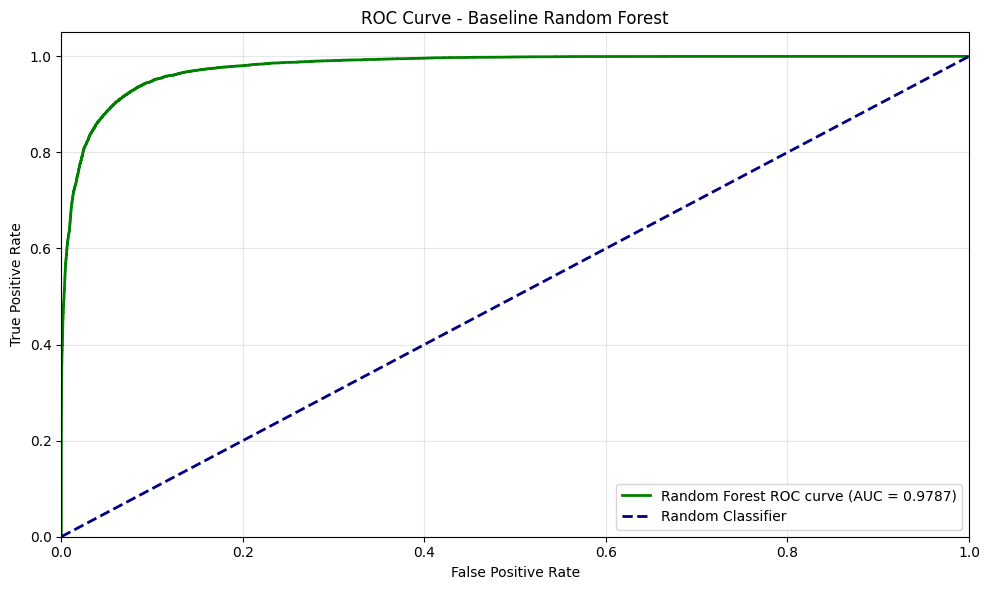

In [21]:
# ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf_baseline)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf_baseline)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, 
         label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline Random Forest')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Precision-Recall Curve - Random Forest Model

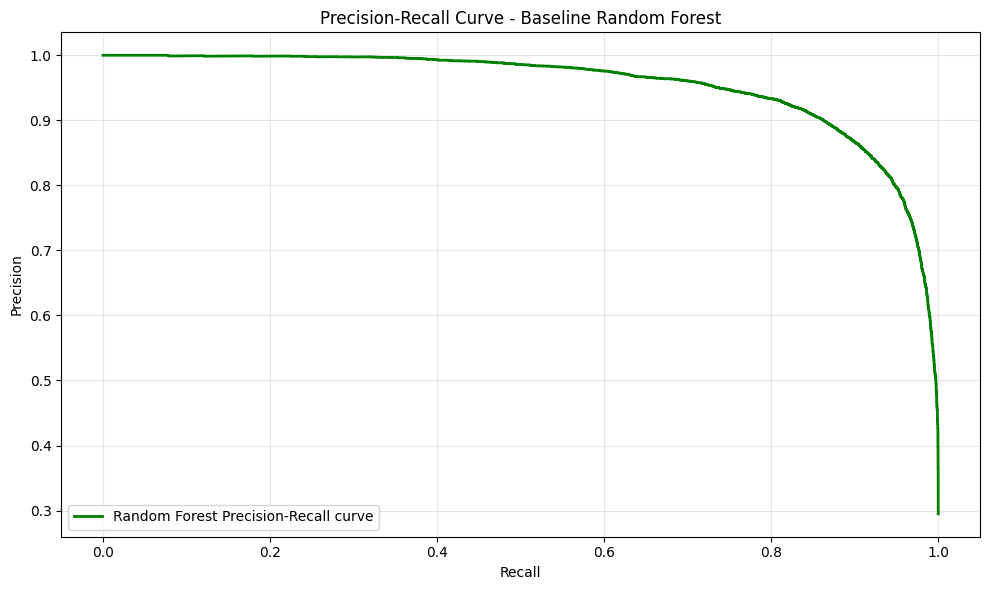

In [22]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve
precision_rf, recall_rf, thresholds_pr_rf = precision_recall_curve(
    y_test, y_pred_proba_rf_baseline
)

plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, color='green', lw=2, 
         label='Random Forest Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Baseline Random Forest')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Hyperparameter Tuning with RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

print("\n" + "="*60)
print("HYPERPARAMETER TUNING WITH RANDOMIZEDSEARCHCV")
print("="*60)

# Define parameter distributions for RandomizedSearch
# RandomizedSearch is faster than GridSearch for Random Forest
param_distributions = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_samples': [0.7, 0.8, 0.9, None]
}

# Alternative: Smaller parameter grid for faster tuning
param_distributions_small = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']
}

# Choose which parameter set to use
param_to_use = param_distributions  # Use full set
# param_to_use = param_distributions_small  # Use for faster tuning

# Create base model
rf_model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    verbose=0
)

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
print("\nStarting RandomizedSearchCV...")
print(f"Testing {100} random combinations from parameter space")
print("This may take several minutes...\n")

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_to_use,
    n_iter=100,  # Number of random combinations to try
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Fit RandomizedSearchCV
random_search_rf.fit(X_train, y_train)

print("\nRandomizedSearchCV completed!")
print(f"\nBest parameters: {random_search_rf.best_params_}")
print(f"Best cross-validation ROC-AUC score: {random_search_rf.best_score_:.4f}")

Evaluate Tuned Random Forest Model

In [ ]:
print("\n" + "="*60)
print("TUNED RANDOM FOREST PERFORMANCE")
print("="*60)

# Get best model
best_rf = random_search_rf.best_estimator_

# Make predictions with tuned model
y_pred_rf_tuned = best_rf.predict(X_test)
y_pred_proba_rf_tuned = best_rf.predict_proba(X_test)[:, 1]

# Evaluate tuned model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_tuned, 
                          target_names=['No Dementia', 'Dementia']))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf_tuned):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf_tuned):.4f}")

# Compare baseline vs tuned
print("\n" + "="*60)
print("BASELINE vs TUNED RANDOM FOREST COMPARISON")
print("="*60)

import pandas as pd
comparison_rf = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [
        accuracy_score(y_test, y_pred_rf_baseline),
        precision_score(y_test, y_pred_rf_baseline),
        recall_score(y_test, y_pred_rf_baseline),
        f1_score(y_test, y_pred_rf_baseline),
        roc_auc_score(y_test, y_pred_proba_rf_baseline)
    ],
    'Tuned': [
        accuracy_score(y_test, y_pred_rf_tuned),
        precision_score(y_test, y_pred_rf_tuned),
        recall_score(y_test, y_pred_rf_tuned),
        f1_score(y_test, y_pred_rf_tuned),
        roc_auc_score(y_test, y_pred_proba_rf_tuned)
    ]
})
comparison_rf['Improvement'] = comparison_rf['Tuned'] - comparison_rf['Baseline']
print(comparison_rf.to_string(index=False))

Feature Importance Analysis - Random Forest Model

In [ ]:
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from the tuned model
feature_importance_rf = best_rf.feature_importances_

# Create a DataFrame
feature_importance_rf_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_rf
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_rf_df.head(20))

# Visualize top 20 features
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf_df.head(20)
plt.barh(top_features_rf['Feature'], top_features_rf['Importance'], 
         color='forestgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances - Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save feature importance to CSV
feature_importance_rf_df.to_csv('feature_importance_random_forest.csv', index=False)
print("\nFeature importance saved to 'feature_importance_random_forest.csv'")

Cross-Validation Performance -Random Forest Model

In [ ]:
from sklearn.model_selection import cross_val_score

print("\n" + "="*60)
print("CROSS-VALIDATION PERFORMANCE")
print("="*60)

# Perform cross-validation on the best model
cv_scores_rf = cross_val_score(
    best_rf, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"\nCross-Validation ROC-AUC Scores: {cv_scores_rf}")
print(f"Mean CV ROC-AUC: {cv_scores_rf.mean():.4f}")
print(f"Std CV ROC-AUC: {cv_scores_rf.std():.4f}")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores_rf, marker='o', linestyle='-', 
         color='green', linewidth=2, markersize=8)
plt.axhline(y=cv_scores_rf.mean(), color='red', linestyle='--', 
            label=f'Mean: {cv_scores_rf.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('ROC-AUC Score')
plt.title('Cross-Validation ROC-AUC Scores - Random Forest')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Out-of-Bag (OOB) Score - Random Forest Model 

In [ ]:
# Random Forest specific: Out-of-Bag Score
if best_rf.bootstrap:
    print("\n" + "="*60)
    print("OUT-OF-BAG (OOB) SCORE")
    print("="*60)
    
    # Retrain with oob_score enabled
    rf_with_oob = RandomForestClassifier(
        **best_rf.get_params(),
        oob_score=True,
        random_state=42
    )
    rf_with_oob.fit(X_train, y_train)
    
    print(f"\nOOB Score: {rf_with_oob.oob_score_:.4f}")
    print("(OOB score is an unbiased estimate of test set performance)")
else:
    print("\nOOB score not available (bootstrap=False)")

Learning Curves - Random Forest Model

In [ ]:
from sklearn.model_selection import learning_curve

print("\n" + "="*60)
print("GENERATING LEARNING CURVES")
print("="*60)

# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_rf,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='green')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='orange')
plt.plot(train_sizes, train_scores_mean, 'o-', color='green', 
         label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', 
         label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('ROC-AUC Score')
plt.title('Learning Curves - Random Forest')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Save the Random Forest Model

In [ ]:
import pickle

print("\n" + "="*60)
print("SAVING THE RANDOM FOREST MODEL")
print("="*60)

# Save the best model
model_filename_rf = 'random_forest_dementia_model.pkl'
with open(model_filename_rf, 'wb') as file:
    pickle.dump(best_rf, file)

print(f"\nModel saved as '{model_filename_rf}'")

# Save model parameters
params_filename_rf = 'random_forest_best_params.txt'
with open(params_filename_rf, 'w') as f:
    f.write("Best Random Forest Parameters:\n")
    f.write("="*50 + "\n")
    for param, value in random_search_rf.best_params_.items():
        f.write(f"{param}: {value}\n")
    f.write("\n" + "="*50 + "\n")
    f.write(f"Best CV ROC-AUC Score: {random_search_rf.best_score_:.4f}\n")

print(f"Best parameters saved to '{params_filename_rf}'")

# Test loading the model
with open(model_filename_rf, 'rb') as file:
    loaded_rf_model = pickle.load(file)

# Verify loaded model works
test_prediction_rf = loaded_rf_model.predict(X_test[:5])
print(f"\nModel loaded successfully! Test prediction: {test_prediction_rf}")

Generate Final Random Forest Report

In [ ]:
print("\n" + "="*60)
print("RANDOM FOREST MODEL - FINAL REPORT")
print("="*60)

final_report_rf = f"""
Random Forest Dementia Prediction Model - Final Report
{'='*60}

Dataset Information:
- Total samples: {df.shape[0]}
- Total features: {X.shape[1]}
- Training samples: {X_train.shape[0]}
- Test samples: {X_test.shape[0]}

Best Hyperparameters:
{random_search_rf.best_params_}

Model Performance on Test Set:
- Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}
- Precision: {precision_score(y_test, y_pred_rf_tuned):.4f}
- Recall: {recall_score(y_test, y_pred_rf_tuned):.4f}
- F1-Score: {f1_score(y_test, y_pred_rf_tuned):.4f}
- ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf_tuned):.4f}

Cross-Validation Performance:
- Mean CV ROC-AUC: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})

Top 5 Most Important Features:
{feature_importance_rf_df.head(5).to_string(index=False)}

Model saved as: {model_filename_rf}
"""

print(final_report_rf)

# Save report to file
with open('random_forest_model_report.txt', 'w') as f:
    f.write(final_report_rf)

print("\nReport saved to 'random_forest_model_report.txt'")
print("\n" + "="*60)
print("RANDOM FOREST MODEL TRAINING COMPLETE!")
print("="*60)

Import LightGBM and Build Baseline Model

In [24]:
print("="*80)
print("LIGHTGBM MODEL TRAINING")
print("="*80)

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, accuracy_score, precision_score, 
                             recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Build baseline LightGBM
print("\n" + "="*60)
print("BUILDING BASELINE LIGHTGBM MODEL")
print("="*60)

baseline_lgb = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    num_leaves=31,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1,
    verbose=-1,  # Suppress warnings
    force_col_wise=True
)

# Train baseline model
print("\nTraining baseline LightGBM...")
baseline_lgb.fit(X_train, y_train)
print("Training completed!")

# Make predictions
y_pred_lgb_baseline = baseline_lgb.predict(X_test)
y_pred_proba_lgb_baseline = baseline_lgb.predict_proba(X_test)[:, 1]

# Evaluate baseline model
print("\n" + "="*60)
print("BASELINE LIGHTGBM PERFORMANCE")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb_baseline, 
                          target_names=['No Dementia', 'Dementia']))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lgb_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb_baseline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgb_baseline):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgb_baseline):.4f}")

LIGHTGBM MODEL TRAINING

BUILDING BASELINE LIGHTGBM MODEL

Training baseline LightGBM...
Training completed!

BASELINE LIGHTGBM PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

 No Dementia       0.97      0.93      0.95     27521
    Dementia       0.84      0.94      0.89     11518

    accuracy                           0.93     39039
   macro avg       0.91      0.93      0.92     39039
weighted avg       0.93      0.93      0.93     39039


Accuracy: 0.9298
Precision: 0.8414
Recall: 0.9392
F1-Score: 0.8876
ROC-AUC: 0.9833


Confusion Matrix Visualization - LightGBM 

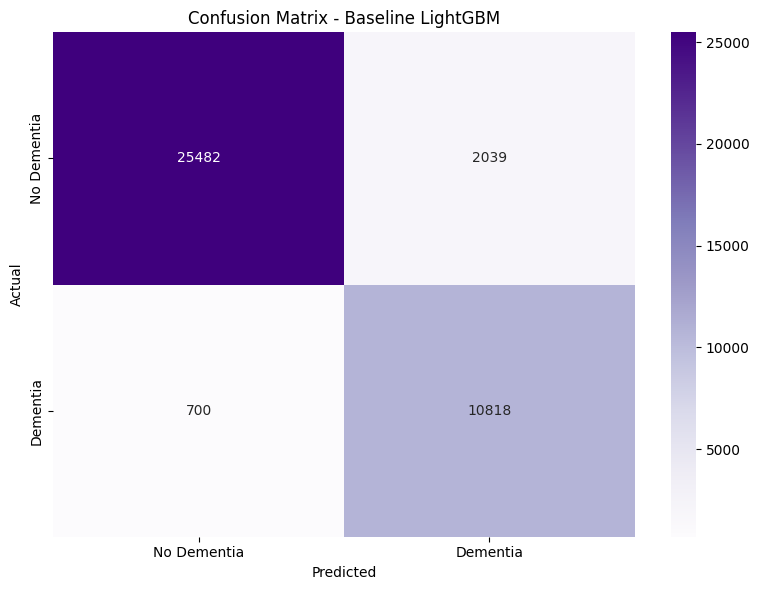


True Negatives: 25482
False Positives: 2039
False Negatives: 700
True Positives: 10818

Specificity: 0.9259
Sensitivity (Recall): 0.9392


In [25]:
# Confusion Matrix
cm_lgb = confusion_matrix(y_test, y_pred_lgb_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['No Dementia', 'Dementia'],
            yticklabels=['No Dementia', 'Dementia'])
plt.title('Confusion Matrix - Baseline LightGBM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm_lgb.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Specificity and Sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\nSpecificity: {specificity:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")

ROC Curve - LightGBM 

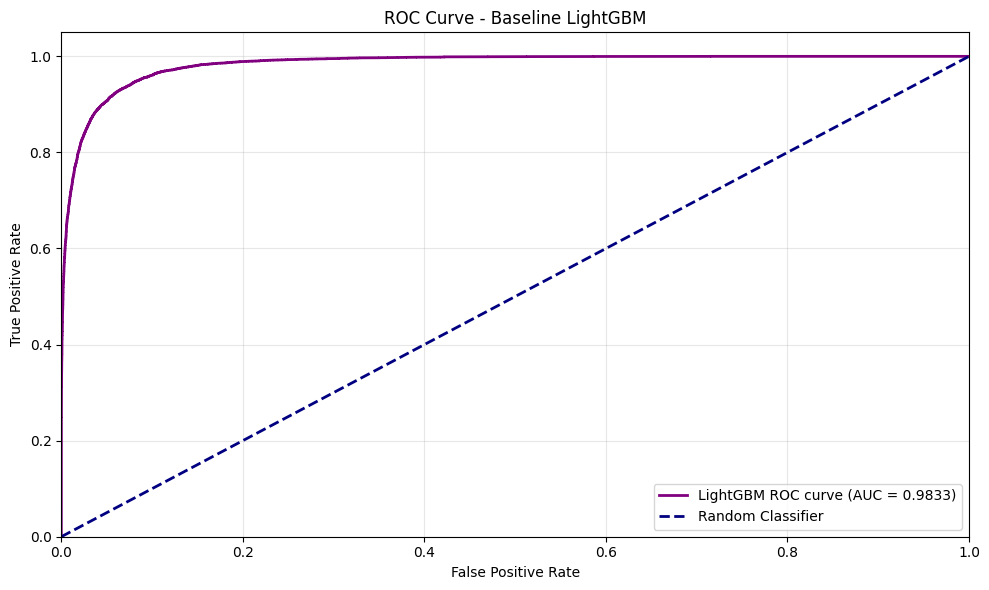

In [26]:
# ROC Curve
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_pred_proba_lgb_baseline)
roc_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb_baseline)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lgb, tpr_lgb, color='purple', lw=2, 
         label=f'LightGBM ROC curve (AUC = {roc_auc_lgb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline LightGBM')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Precision-Recall Curve - LightGBM 

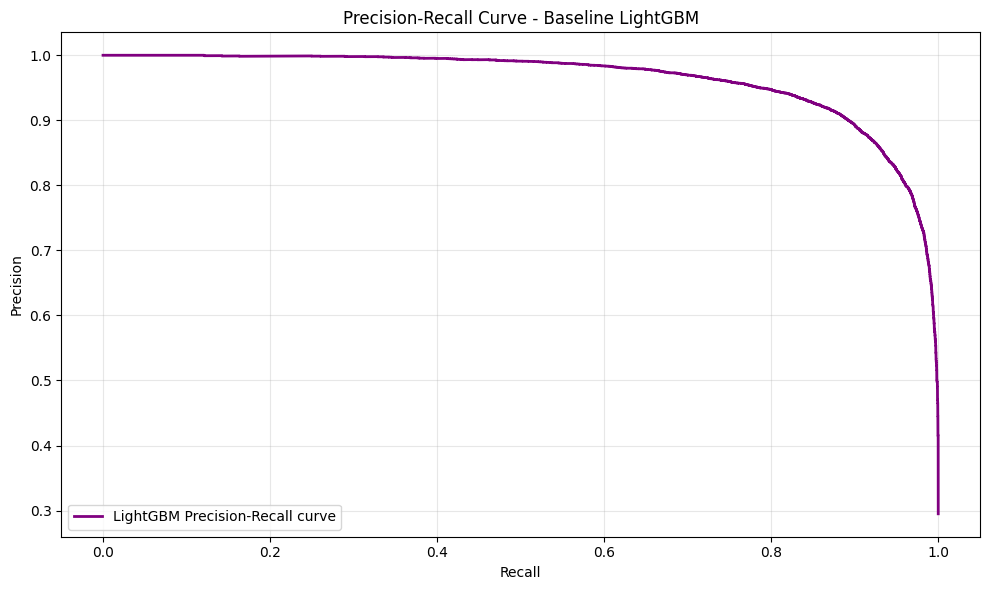

In [27]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve
precision_lgb, recall_lgb, thresholds_pr_lgb = precision_recall_curve(
    y_test, y_pred_proba_lgb_baseline
)

plt.figure(figsize=(10, 6))
plt.plot(recall_lgb, precision_lgb, color='purple', lw=2, 
         label='LightGBM Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Baseline LightGBM')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Hyperparameter Tuning with GridSearchCV - LightGBM 

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

print("\n" + "="*60)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*60)

# Define parameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, -1],  # -1 means no limit
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 70, 100],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30, 50],
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1],  # L2 regularization
    'min_split_gain': [0.0, 0.1, 0.2]
}

# Smaller parameter grid for faster tuning
param_grid_lgb_small = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'min_child_samples': [20, 30],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

# Choose which parameter set to use
param_to_use_lgb = param_grid_lgb_small  # Use small set for faster tuning
# param_to_use_lgb = param_grid_lgb  # Use for comprehensive tuning

# Create base model
lgb_model = LGBMClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    verbose=-1,
    force_col_wise=True
)

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
print("\nStarting GridSearchCV...")
total_combinations = np.prod([len(v) for v in param_to_use_lgb.values()])
print(f"Total combinations to test: {total_combinations}")
print("This may take several minutes...\n")

grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_to_use_lgb,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit GridSearchCV
grid_search_lgb.fit(X_train, y_train)

print("\nGridSearchCV completed!")
print(f"\nBest parameters: {grid_search_lgb.best_params_}")
print(f"Best cross-validation ROC-AUC score: {grid_search_lgb.best_score_:.4f}")

Evaluate Tuned LightGBM Model 

In [ ]:
print("\n" + "="*60)
print("TUNED LIGHTGBM PERFORMANCE")
print("="*60)

# Get best model
best_lgb = grid_search_lgb.best_estimator_

# Make predictions with tuned model
y_pred_lgb_tuned = best_lgb.predict(X_test)
y_pred_proba_lgb_tuned = best_lgb.predict_proba(X_test)[:, 1]

# Evaluate tuned model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb_tuned, 
                          target_names=['No Dementia', 'Dementia']))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lgb_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgb_tuned):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgb_tuned):.4f}")

# Compare baseline vs tuned
print("\n" + "="*60)
print("BASELINE vs TUNED LIGHTGBM COMPARISON")
print("="*60)

comparison_lgb = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [
        accuracy_score(y_test, y_pred_lgb_baseline),
        precision_score(y_test, y_pred_lgb_baseline),
        recall_score(y_test, y_pred_lgb_baseline),
        f1_score(y_test, y_pred_lgb_baseline),
        roc_auc_score(y_test, y_pred_proba_lgb_baseline)
    ],
    'Tuned': [
        accuracy_score(y_test, y_pred_lgb_tuned),
        precision_score(y_test, y_pred_lgb_tuned),
        recall_score(y_test, y_pred_lgb_tuned),
        f1_score(y_test, y_pred_lgb_tuned),
        roc_auc_score(y_test, y_pred_proba_lgb_tuned)
    ]
})
comparison_lgb['Improvement'] = comparison_lgb['Tuned'] - comparison_lgb['Baseline']
print(comparison_lgb.to_string(index=False))

Confusion Matrix for Tuned Model - LightGBM 

In [ ]:
# Confusion Matrix for Tuned Model
cm_lgb_tuned = confusion_matrix(y_test, y_pred_lgb_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgb_tuned, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['No Dementia', 'Dementia'],
            yticklabels=['No Dementia', 'Dementia'])
plt.title('Confusion Matrix - Tuned LightGBM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

Feature Importance Analysis - LightGBM 

In [ ]:
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from the tuned model
feature_importance_lgb = best_lgb.feature_importances_

# Create a DataFrame
feature_importance_lgb_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_lgb
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_lgb_df.head(20))

# Visualize top 20 features
plt.figure(figsize=(12, 8))
top_features_lgb = feature_importance_lgb_df.head(20)
plt.barh(top_features_lgb['Feature'], top_features_lgb['Importance'], 
         color='mediumpurple')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances - LightGBM Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save feature importance to CSV
feature_importance_lgb_df.to_csv('feature_importance_lightgbm.csv', index=False)
print("\nFeature importance saved to 'feature_importance_lightgbm.csv'")

Cross-Validation Performance - LightGBM 

In [ ]:
from sklearn.model_selection import cross_val_score

print("\n" + "="*60)
print("CROSS-VALIDATION PERFORMANCE")
print("="*60)

# Perform cross-validation on the best model
cv_scores_lgb = cross_val_score(
    best_lgb, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"\nCross-Validation ROC-AUC Scores: {cv_scores_lgb}")
print(f"Mean CV ROC-AUC: {cv_scores_lgb.mean():.4f}")
print(f"Std CV ROC-AUC: {cv_scores_lgb.std():.4f}")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores_lgb, marker='o', linestyle='-', 
         color='purple', linewidth=2, markersize=8)
plt.axhline(y=cv_scores_lgb.mean(), color='red', linestyle='--', 
            label=f'Mean: {cv_scores_lgb.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('ROC-AUC Score')
plt.title('Cross-Validation ROC-AUC Scores - LightGBM')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

LightGBM Training History (Loss Curve)

In [ ]:
print("\n" + "="*60)
print("TRAINING HISTORY - LOSS CURVE")
print("="*60)

# Retrain with evaluation set to get training history
lgb_with_eval = LGBMClassifier(
    **best_lgb.get_params(),
    random_state=42
)

# Train with evaluation set
eval_set = [(X_train, y_train), (X_test, y_test)]
lgb_with_eval.fit(
    X_train, 
    y_train,
    eval_set=eval_set,
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Get evaluation results
results = lgb_with_eval.evals_result_

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(results['training']['auc'], label='Training AUC', color='blue')
plt.plot(results['valid_1']['auc'], label='Validation AUC', color='orange')
plt.xlabel('Iteration')
plt.ylabel('AUC Score')
plt.title('LightGBM Training History')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest iteration: {lgb_with_eval.best_iteration_}")
print(f"Training stopped at iteration: {len(results['training']['auc'])}")

Learning Curves - LightGBM 

In [ ]:
from sklearn.model_selection import learning_curve

print("\n" + "="*60)
print("GENERATING LEARNING CURVES")
print("="*60)

# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_lgb,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='purple')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='orange')
plt.plot(train_sizes, train_scores_mean, 'o-', color='purple', 
         label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', 
         label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('ROC-AUC Score')
plt.title('Learning Curves - LightGBM')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Save the LightGBM Model

In [ ]:
import pickle

print("\n" + "="*60)
print("SAVING THE LIGHTGBM MODEL")
print("="*60)

# Save the best model
model_filename_lgb = 'lightgbm_dementia_model.pkl'
with open(model_filename_lgb, 'wb') as file:
    pickle.dump(best_lgb, file)

print(f"\nModel saved as '{model_filename_lgb}'")

# Also save as LightGBM native format (optional, more efficient)
best_lgb.booster_.save_model('lightgbm_dementia_model.txt')
print("Model also saved in LightGBM native format: 'lightgbm_dementia_model.txt'")

# Save model parameters
params_filename_lgb = 'lightgbm_best_params.txt'
with open(params_filename_lgb, 'w') as f:
    f.write("Best LightGBM Parameters:\n")
    f.write("="*50 + "\n")
    for param, value in grid_search_lgb.best_params_.items():
        f.write(f"{param}: {value}\n")
    f.write("\n" + "="*50 + "\n")
    f.write(f"Best CV ROC-AUC Score: {grid_search_lgb.best_score_:.4f}\n")

print(f"Best parameters saved to '{params_filename_lgb}'")

# Test loading the model
with open(model_filename_lgb, 'rb') as file:
    loaded_lgb_model = pickle.load(file)

# Verify loaded model works
test_prediction_lgb = loaded_lgb_model.predict(X_test[:5])
print(f"\nModel loaded successfully! Test prediction: {test_prediction_lgb}")

Generate Final LightGBM Report

In [ ]:
print("\n" + "="*60)
print("LIGHTGBM MODEL - FINAL REPORT")
print("="*60)

final_report_lgb = f"""
LightGBM Dementia Prediction Model - Final Report
{'='*60}

Dataset Information:
- Total samples: {df.shape[0]}
- Total features: {X.shape[1]}
- Training samples: {X_train.shape[0]}
- Test samples: {X_test.shape[0]}

Best Hyperparameters:
{grid_search_lgb.best_params_}

Model Performance on Test Set:
- Accuracy: {accuracy_score(y_test, y_pred_lgb_tuned):.4f}
- Precision: {precision_score(y_test, y_pred_lgb_tuned):.4f}
- Recall: {recall_score(y_test, y_pred_lgb_tuned):.4f}
- F1-Score: {f1_score(y_test, y_pred_lgb_tuned):.4f}
- ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgb_tuned):.4f}

Cross-Validation Performance:
- Mean CV ROC-AUC: {cv_scores_lgb.mean():.4f} (+/- {cv_scores_lgb.std():.4f})

Training Information:
- Best iteration: {lgb_with_eval.best_iteration_}
- Total iterations: {len(results['training']['auc'])}

Top 5 Most Important Features:
{feature_importance_lgb_df.head(5).to_string(index=False)}

Model saved as: {model_filename_lgb}
"""

print(final_report_lgb)

# Save report to file
with open('lightgbm_model_report.txt', 'w') as f:
    f.write(final_report_lgb)

print("\nReport saved to 'lightgbm_model_report.txt'")
print("\n" + "="*60)
print("LIGHTGBM MODEL TRAINING COMPLETE!")
print("="*60)